<a href="https://colab.research.google.com/github/reitezuz/notebooks-for-NES2-2024/blob/main/lecture_09/simple_time_series.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Tme series prediction - Jena Climate Dataset

Inspired by: https://github.com/fchollet/deep-learning-with-python-notebooks/blob/master/chapter10_dl-for-timeseries.ipynb

# Jena Climate Dataset
The dataset contains meteorological data recorded in Jena, Germany, from 2009 to 2016. Measurement frequency: Every 10 minutes. It is suitable for time series analysis and weather prediction.
- File type: CSV (compressed in a ZIP file).

**Variables:**
- `Datetime` - Date and time of measurement.
- `Temperature (°C)` - Temperature in Celsius.
- `Pressure (hPa)` - Atmospheric pressure in hectopascals.
- `Humidity (%)` - Relative humidity.
- `Wind speed (m/s)` - Wind speed in meters per second.
- `Wind direction (°)` - Wind direction in degrees.
- `Radiation (W/m²)` - Solar radiation intensity.

**Uses:**
- Temperature or other meteorological variable prediction.
- Seasonal and trend analysis in time series data.

**Source:**
Dataset download: [jena_climate_2009_2016.csv.zip](https://s3.amazonaws.com/keras-datasets/jena_climate_2009_2016.csv.zip)


1. Download the zip file with the data
2. Extract the zip file

In [1]:
!wget https://s3.amazonaws.com/keras-datasets/jena_climate_2009_2016.csv.zip
!unzip jena_climate_2009_2016.csv.zip

import os
# Clean up by removing the downloaded zip file
os.remove("jena_climate_2009_2016.csv.zip")


--2024-11-27 11:57:09--  https://s3.amazonaws.com/keras-datasets/jena_climate_2009_2016.csv.zip
Resolving s3.amazonaws.com (s3.amazonaws.com)... 54.231.134.232, 52.217.206.200, 54.231.225.176, ...
Connecting to s3.amazonaws.com (s3.amazonaws.com)|54.231.134.232|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 13565642 (13M) [application/zip]
Saving to: ‘jena_climate_2009_2016.csv.zip’

jena_climate_2009_2 100%[===================>]  12.94M  5.97MB/s    in 2.2s    

2024-11-27 11:57:12 (5.97 MB/s) - ‘jena_climate_2009_2016.csv.zip’ saved [13565642/13565642]

Archive:  jena_climate_2009_2016.csv.zip
  inflating: jena_climate_2009_2016.csv  
  inflating: __MACOSX/._jena_climate_2009_2016.csv  


## Observe the data

In [24]:
import pandas as pd
import numpy as np
import os

file_path = "jena_climate_2009_2016.csv"

# Read the CSV file into a pandas DataFrame
df = pd.read_csv(file_path)

# Extract header and number of rows using pandas
header = list(df.columns)
num_rows = len(df)

# Extract 'Temperature (°C)' column into temperature array
temperature = df['T (degC)'].values

# Create raw_data array (excluding the Date Time column)
raw_data = df.drop(columns=['Date Time']).values


print("Header:", header)
print("Number of columns:", len(header))
print("Number of rows:", num_rows)
print("Temperature array shape:", temperature.shape)
print("Raw data array shape:", raw_data.shape)

# Example: Display first few rows of the DataFrame
print(df.head())



Header: ['Date Time', 'p (mbar)', 'T (degC)', 'Tpot (K)', 'Tdew (degC)', 'rh (%)', 'VPmax (mbar)', 'VPact (mbar)', 'VPdef (mbar)', 'sh (g/kg)', 'H2OC (mmol/mol)', 'rho (g/m**3)', 'wv (m/s)', 'max. wv (m/s)', 'wd (deg)']
Number of columns: 15
Number of rows: 420451
Temperature array shape: (420451,)
Raw data array shape: (420451, 14)
             Date Time  p (mbar)  T (degC)  Tpot (K)  Tdew (degC)  rh (%)  \
0  01.01.2009 00:10:00    996.52     -8.02    265.40        -8.90    93.3   
1  01.01.2009 00:20:00    996.57     -8.41    265.01        -9.28    93.4   
2  01.01.2009 00:30:00    996.53     -8.51    264.91        -9.31    93.9   
3  01.01.2009 00:40:00    996.51     -8.31    265.12        -9.07    94.2   
4  01.01.2009 00:50:00    996.51     -8.27    265.15        -9.04    94.1   

   VPmax (mbar)  VPact (mbar)  VPdef (mbar)  sh (g/kg)  H2OC (mmol/mol)  \
0          3.33          3.11          0.22       1.94             3.12   
1          3.23          3.02          0.21       1.

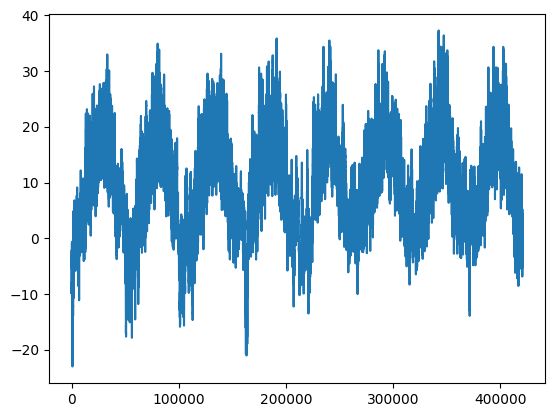

In [25]:
# Plotting the temperature timeseries
from matplotlib import pyplot as plt
plt.plot(range(len(temperature)), temperature)

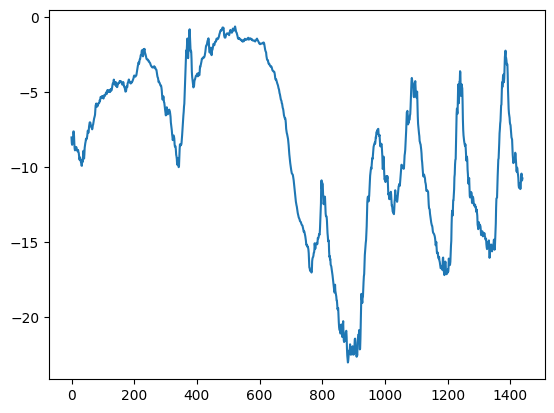

In [26]:
# Plotting the first 10 days of the temperature timeseries
plt.plot(range(1440), temperature[:1440])

## Example: create a simple timeseries training set from an array:

https://keras.io/api/data_loading/timeseries/

In [27]:
import numpy as np
from tensorflow import keras
int_sequence = np.arange(10)
print(int_sequence)
dummy_dataset = keras.utils.timeseries_dataset_from_array(
    data=int_sequence[:-3],
    targets=int_sequence[3:],
    sequence_length=3,
    batch_size=2,
)

for inputs, targets in dummy_dataset:
    for i in range(inputs.shape[0]):
        print([int(x) for x in inputs[i]], int(targets[i]))

[0 1 2 3 4 5 6 7 8 9]
[0, 1, 2] 3
[1, 2, 3] 4
[2, 3, 4] 5
[3, 4, 5] 6
[4, 5, 6] 7


## Our task

- We will use only data measured once per hour instead of all data (measured every 10 minutes).
- Based on the values from the previous 5 days, we will predict the temperature 24 hours ahead.

## Prepare the data

In [28]:
num_train_samples = int(0.5 * len(raw_data)) # 50 % training data
num_val_samples = int(0.25 * len(raw_data))  # 25 % validation and testing data
num_test_samples = len(raw_data) - num_train_samples - num_val_samples
print("num_train_samples:", num_train_samples)
print("num_val_samples:", num_val_samples)
print("num_test_samples:", num_test_samples)

# Normalize the data:
mean = raw_data[:num_train_samples].mean(axis=0)
raw_data -= mean
std = raw_data[:num_train_samples].std(axis=0)
raw_data /= std

# Create the training, validation and testing data sets:
sampling_rate = 6        # we will use each 6th sample (1 per hour)
sequence_length = 120    # we will use 120 hours (5 days)
delay = sampling_rate * (sequence_length + 24 - 1) # target: value 24 hours after the end of sequence
batch_size = 256

train_dataset = keras.utils.timeseries_dataset_from_array(
    raw_data[:-delay],
    targets=temperature[delay:],
    sampling_rate=sampling_rate,
    sequence_length=sequence_length,
    shuffle=True,
    batch_size=batch_size,
    start_index=0,
    end_index=num_train_samples)

val_dataset = keras.utils.timeseries_dataset_from_array(
    raw_data[:-delay],
    targets=temperature[delay:],
    sampling_rate=sampling_rate,
    sequence_length=sequence_length,
    shuffle=True,
    batch_size=batch_size,
    start_index=num_train_samples,
    end_index=num_train_samples + num_val_samples)

test_dataset = keras.utils.timeseries_dataset_from_array(
    raw_data[:-delay],
    targets=temperature[delay:],
    sampling_rate=sampling_rate,
    sequence_length=sequence_length,
    shuffle=True,
    batch_size=batch_size,
    start_index=num_train_samples + num_val_samples)



# Remove incomplete batches (batches smaller than `batch_size`)
# Needed by Flatten layer of MLP
'''
import tensorflow as tf
train_dataset = train_dataset.filter(lambda x, y: tf.shape(x)[0] == batch_size)
val_dataset = val_dataset.filter(lambda x, y: tf.shape(x)[0] == batch_size)
test_dataset = test_dataset.filter(lambda x, y: tf.shape(x)[0] == batch_size)
'''

for samples, targets in train_dataset:
    print("samples shape:", samples.shape)
    print("targets shape:", targets.shape)
    break

num_train_samples: 210225
num_val_samples: 105112
num_test_samples: 105114
samples shape: (256, 120, 14)
targets shape: (256,)


## Computing the common-sense baseline MAE
- predict the temperature 24 hours ago

In [29]:
def evaluate_naive_method(dataset):
    total_abs_err = 0.
    samples_seen = 0
    for samples, targets in dataset:
        preds = samples[:, -1, 1] * std[1] + mean[1]
        total_abs_err += np.sum(np.abs(preds - targets))
        samples_seen += samples.shape[0]
    return total_abs_err / samples_seen

print(f"Validation MAE: {evaluate_naive_method(val_dataset):.2f}")
print(f"Test MAE: {evaluate_naive_method(test_dataset):.2f}")

Validation MAE: 2.44
Test MAE: 2.62


## Define and train the model: a simple MLP

In [ ]:
'''
for samples, targets in train_dataset:
  if samples.shape != (256, 120, 14) or targets.shape != (256,):
    print("samples shape:", samples.shape)
    print("targets shape:", targets.shape)
    break
'''

In [ ]:
'''
import numpy as np

# Assuming 'train_dataset' is defined as in the provided code

# Flatten the input samples
flattened_train_data = []
train_targets = []
for samples, targets in train_dataset:
  flattened_train_data.append(np.reshape(samples, (samples.shape[0], -1)))  # Flatten each sample in the batch
  train_targets.extend(targets.numpy()) #targets to a list


flattened_train_data = np.concatenate(flattened_train_data, axis=0)
train_targets = np.array(train_targets)


print("Flattened training data shape:", flattened_train_data.shape)
print("Training targets shape:", train_targets.shape)
'''

In [ ]:
'''

# Flatten the validation samples
flattened_val_data = []
val_targets = []
for samples, targets in val_dataset:
  flattened_val_data.append(np.reshape(samples, (samples.shape[0], -1)))
  val_targets.extend(targets.numpy())

flattened_val_data = np.concatenate(flattened_val_data, axis=0)
val_targets = np.array(val_targets)

print("Flattened validation data shape:", flattened_val_data.shape)
print("Validation targets shape:", val_targets.shape)


# Flatten the test samples
flattened_test_data = []
test_targets = []
for samples, targets in test_dataset:
  flattened_test_data.append(np.reshape(samples, (samples.shape[0], -1)))
  test_targets.extend(targets.numpy())

flattened_test_data = np.concatenate(flattened_test_data, axis=0)
test_targets = np.array(test_targets)

print("Flattened test data shape:", flattened_test_data.shape)
print("Test targets shape:", test_targets.shape)
'''

In [ ]:
'''
import keras
from keras import layers

# Define the simple MLP model
inputs = keras.Input(shape=flattened_train_data.shape)  # Match sequence length and number of features
x = layers.Dense(16, activation="relu")(inputs)  # Fully connected layer
outputs = layers.Dense(1)(x)  # Output layer for single target


model = keras.Model(inputs, outputs)
model.summary()

print(sequence_length, raw_data.shape[-1])
print(train_dataset)

callbacks = [
    keras.callbacks.ModelCheckpoint("jena_dense.keras",
                                    save_best_only=True)
]
model.compile(optimizer="rmsprop", loss="mse", metrics=["mae"])

history = model.fit(flattened_train_data, train_targets,
                    epochs=10,
                    batch_size = batch_size,
                    validation_data= (flattened_val_data, val_targets),
                    callbacks=callbacks)

model = keras.models.load_model("jena_dense.keras")
print(f"Test MAE: {model.evaluate(flattened_test_data, test_targets)[1]:.2f}")



import matplotlib.pyplot as plt
loss = history.history["mae"]
val_loss = history.history["val_mae"]
epochs = range(1, len(loss) + 1)
plt.figure()
plt.plot(epochs, loss, "b", label="Training MAE")
plt.plot(epochs, val_loss, "k", label="Validation MAE")
plt.title("Training and validation MAE")
plt.legend()
plt.show()
'''

In [ ]:
import keras
from keras import layers

def reshape_batch(features, labels):
    # Flatten the last two dimensions  for each sample in the batch
    reshaped_features = tf.reshape(features, (features.shape[0], -1))
    return reshaped_features, labels

reshaped_train_dataset = train_dataset.map(reshape_batch)
reshaped_val_dataset = val_dataset.map(reshape_batch)
reshaped_test_dataset = test_dataset.map(reshape_batch)

inputs = keras.Input(shape=(sequence_length* raw_data.shape[-1],))
#x = layers.Flatten()(inputs)
x = layers.Dense(16, activation="relu")(inputs)
outputs = layers.Dense(1)(x)
model = keras.Model(inputs, outputs)
model.summary()

callbacks = [
    keras.callbacks.ModelCheckpoint("jena_dense.keras",
                                    save_best_only=True)
]
model.compile(optimizer="rmsprop", loss="mse", metrics=["mae"])
history = model.fit(train_dataset,
                    epochs=10,
                    validation_data=reshaped_val_dataset,
                    callbacks=callbacks)

model = keras.models.load_model("jena_dense.keras")
print(f"Validation MAE: {model.evaluate(reshaped_val_dataset)[1]:.2f}")
print(f"Test MAE: {model.evaluate(reshaped_test_dataset)[1]:.2f}")

import matplotlib.pyplot as plt
loss = history.history["mae"]
val_loss = history.history["val_mae"]
epochs = range(1, len(loss) + 1)
plt.figure()
plt.plot(epochs, loss, "b", label="Training MAE")
plt.plot(epochs, val_loss, "k", label="Validation MAE")
plt.title("Training and validation MAE")
plt.legend()
plt.show()

In [36]:

import matplotlib.pyplot as plt

def plot_predictions(dataset, model, num_samples=24):
    """Plots predicted vs. real outputs."""
    preds_list = []
    targets_list = []

    samples_seen = 0
    for samples, targets in dataset:
        preds = model.predict(samples)
        #preds_list.extend(preds)
        preds_list.extend(preds.reshape(-1))
        targets_list.extend(targets)
        samples_seen += samples.shape[0]
        if samples_seen >= num_samples:
            break

    plt.figure(figsize=(10, 6))
    plt.plot(targets_list[:num_samples], label='Real Values')
    plt.plot(preds_list[:num_samples], label='Predicted Values')
    plt.xlabel('Sample Index')
    plt.ylabel('Temperature (°C)')
    plt.title('Predicted vs. Real Temperature')
    plt.legend()
    plt.show()



In [ ]:
model = keras.models.load_model("jena_dense.keras")
plot_predictions(reshaped_test_dataset, model)

##  A 1D convolutional model

Epoch 1/10
819/819 ━━━━━━━━━━━━━━━━━━━━ 42s 49ms/step - loss: 39.0239 - mae: 4.6416 - val_loss: 16.6350 - val_mae: 3.2205
Epoch 2/10
819/819 ━━━━━━━━━━━━━━━━━━━━ 38s 46ms/step - loss: 15.4974 - mae: 3.1154 - val_loss: 14.9768 - val_mae: 3.0637
Epoch 3/10
819/819 ━━━━━━━━━━━━━━━━━━━━ 38s 47ms/step - loss: 14.1588 - mae: 2.9724 - val_loss: 16.8909 - val_mae: 3.2350
Epoch 4/10
819/819 ━━━━━━━━━━━━━━━━━━━━ 42s 48ms/step - loss: 13.2587 - mae: 2.8692 - val_loss: 17.0911 - val_mae: 3.2818
Epoch 5/10
819/819 ━━━━━━━━━━━━━━━━━━━━ 41s 50ms/step - loss: 12.6258 - mae: 2.7964 - val_loss: 17.7728 - val_mae: 3.3126
Epoch 6/10
819/819 ━━━━━━━━━━━━━━━━━━━━ 47s 58ms/step - loss: 12.1000 - mae: 2.7385 - val_loss: 14.9005 - val_mae: 3.0424
Epoch 7/10
819/819 ━━━━━━━━━━━━━━━━━━━━ 47s 57ms/step - loss: 11.6061 - mae: 2.6814 - val_loss: 16.2958 - val_mae: 3.1520
Epoch 8/10
819/819 ━━━━━━━━━━━━━━━━━━━━ 82s 58ms/step - loss: 11.2057 - mae: 2.6343 - val_loss: 15.0621 - val_mae: 3.0322
Epoch 9/10
819/819 ━━━━━

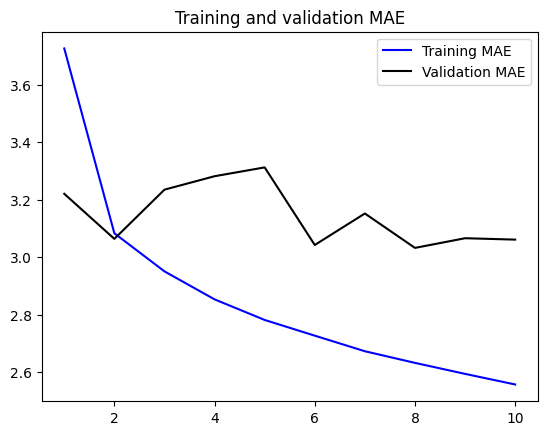

In [37]:
inputs = keras.Input(shape=(sequence_length, raw_data.shape[-1]))
x = layers.Conv1D(8, 24, activation="relu")(inputs)
x = layers.MaxPooling1D(2)(x)
x = layers.Conv1D(8, 12, activation="relu")(x)
x = layers.MaxPooling1D(2)(x)
x = layers.Conv1D(8, 6, activation="relu")(x)
x = layers.GlobalAveragePooling1D()(x)
outputs = layers.Dense(1)(x)
model = keras.Model(inputs, outputs)

callbacks = [
    keras.callbacks.ModelCheckpoint("jena_conv.keras",
                                    save_best_only=True)
]
model.compile(optimizer="rmsprop", loss="mse", metrics=["mae"])
history = model.fit(train_dataset,
                    epochs=10,
                    validation_data=val_dataset,
                    callbacks=callbacks)

model = keras.models.load_model("jena_conv.keras")
print(f"Test MAE: {model.evaluate(test_dataset)[1]:.2f}")


import matplotlib.pyplot as plt
loss = history.history["mae"]
val_loss = history.history["val_mae"]
epochs = range(1, len(loss) + 1)
plt.figure()
plt.plot(epochs, loss, "b", label="Training MAE")
plt.plot(epochs, val_loss, "k", label="Validation MAE")
plt.title("Training and validation MAE")
plt.legend()
plt.show()

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step  


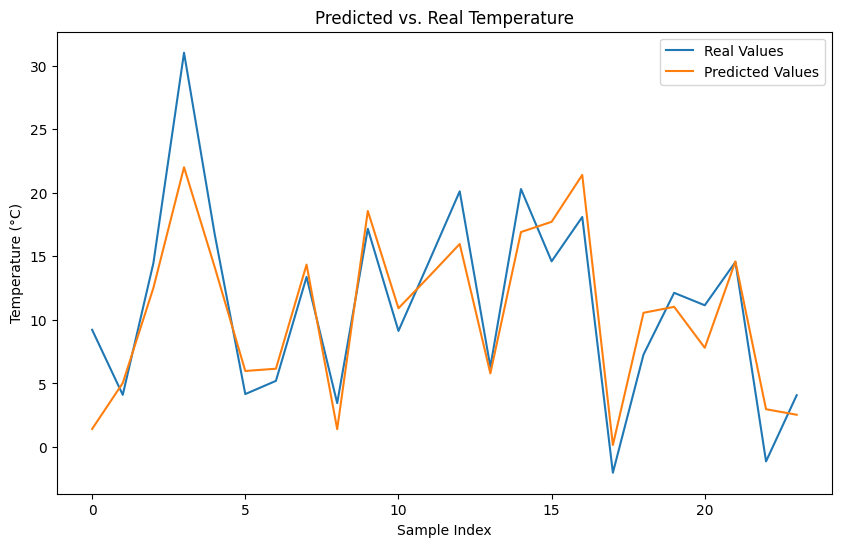

In [38]:
model = keras.models.load_model("jena_conv.keras")
plot_predictions(test_dataset, model, 1000)

# A simple LSTM-based model





Model: "functional_5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_5 (InputLayer)           │ (None, 120, 14)             │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm (LSTM)                          │ (None, 16)                  │           1,984 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_7 (Dense)                      │ (None, 1)                   │              17 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 2,001 (7.82 KB)

 Trainable params: 2,001 (7.82 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/10
819/819 ━━━━━━━━━━━━━━━━━━━━ 43s 51ms/step - loss: 77.1493 - mae: 6.7431 - val_loss: 13.4621 - val_mae: 2.7806
Epoch 2/10
819/819 ━━━━━━━━━━━━━━━━━━━━ 42s 51ms/step - loss: 12.2171 - mae: 2.6991 - val_loss: 9.4563 - val_mae: 2.3924
Epoch 3/10
819/819 ━━━━━━━━━━━━━━━━━━━━ 83s 52ms/step - loss: 9.7488 - mae: 2.4369 - val_loss: 10.1213 - val_mae: 2.4574
Epoch 4/10
819/819 ━━━━━━━━━━━━━━━━━━━━ 50s 60ms/step - loss: 9.1344 - mae: 2.3603 - val_loss: 10.5266 - val_mae: 2.5253
Epoch 5/10
819/819 ━━━━━━━━━━━━━━━━━━━━ 42s 51ms/step - loss: 8.7595 - mae: 2.3119 - val_loss: 10.7301 - val_mae: 2.5478
Epoch 6/10
819/819 ━━━━━━━━━━━━━━━━━━━━ 83s 51ms/step - loss: 8.4658 - mae: 2.2714 - val_loss: 10.9027 - val_mae: 2.5431
Epoch 7/10
819/819 ━━━━━━━━━━━━━━━━━━━━ 81s 50ms/step - loss: 8.2868 - mae: 2.2441 - val_loss: 10.7803 - val_mae: 2.5436
Epoch 8/10
819/819 ━━━━━━━━━━━━━━━━━━━━ 44s 54ms/step - loss: 8.1215 - mae: 2.2213 - val_loss: 10.6739 - val_mae: 2.5430
Epoch 9/10
819/819 ━━━━━━━━━━━━

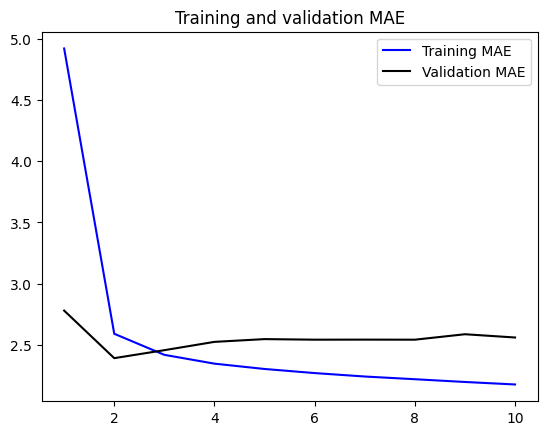

In [39]:
inputs = keras.Input(shape=(sequence_length, raw_data.shape[-1]))
x = layers.LSTM(16)(inputs)
outputs = layers.Dense(1)(x)
model = keras.Model(inputs, outputs)
model.summary()


callbacks = [
    keras.callbacks.ModelCheckpoint("jena_lstm.keras",
                                    save_best_only=True)
]
model.compile(optimizer="rmsprop", loss="mse", metrics=["mae"])
history = model.fit(train_dataset,
                    epochs=10,
                    validation_data=val_dataset,
                    callbacks=callbacks)

model = keras.models.load_model("jena_lstm.keras")
print(f"Test MAE: {model.evaluate(test_dataset)[1]:.2f}")


import matplotlib.pyplot as plt
loss = history.history["mae"]
val_loss = history.history["val_mae"]
epochs = range(1, len(loss) + 1)
plt.figure()
plt.plot(epochs, loss, "b", label="Training MAE")
plt.plot(epochs, val_loss, "k", label="Validation MAE")
plt.title("Training and validation MAE")
plt.legend()
plt.show()

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step  


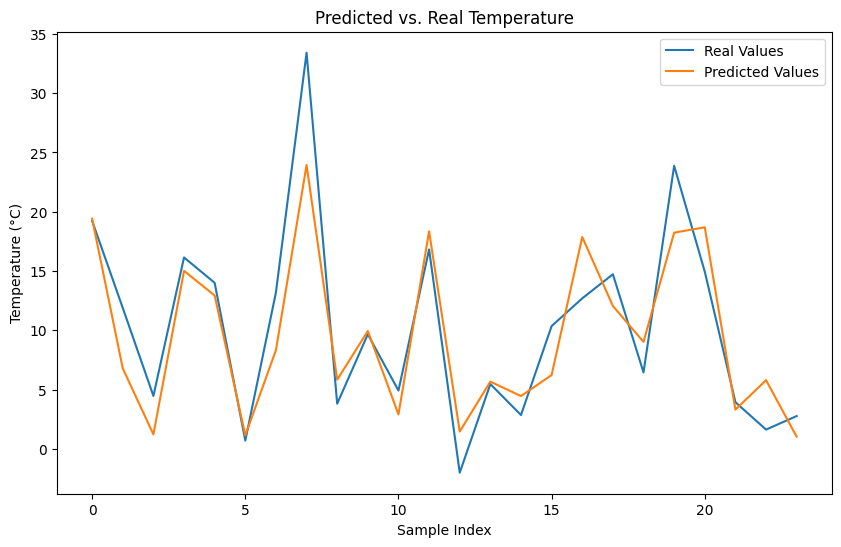

In [40]:
model = keras.models.load_model("jena_lstm.keras")
plot_predictions(test_dataset, model)

## Extended example

In [41]:
# Data frame for results
import pandas as pd

columns = ["Model Name", "Details", "Test MAE", "Train MAE"]
results_df = pd.DataFrame(columns=columns)

In [ ]:
###############################################
# Define the log directory for TensorBoard
import os
import datetime
import keras
import tensorflow as tf

model_datetime_name = "temperature_MLP"+  datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
log_dir = "./logs/temperature/" + model_datetime_name
# print(os.getcwd())

# Clear any logs from previous runs
# !rm -rf ./logs/

# Ensure the directory exists
if not os.path.exists(os.path.dirname(log_dir)):
    os.makedirs(os.path.dirname(log_dir))

###############################################
# Initialize Tensorboard callback
tensorboard_callback = keras.callbacks.TensorBoard(
    log_dir=log_dir,
    histogram_freq=1,  # Visualize histograms of layer weights
    write_graph=True,  # Log the graph to visualize the model structure
    write_images=True  # Optionally, save images of weights and activation histograms
    # update_freq='batch'  # Log metrics after every batch
    # write_steps_per_second=True  # Log steps per second during training
)
################################################

# Define model architecture:
inputs = keras.Input(shape=(sequence_length, raw_data.shape[-1]))
x = layers.Flatten()(inputs)
x = layers.Dense(16, activation="relu")(x)
#x = layers.Dense(16, activation="relu")(inputs)
outputs = layers.Dense(1)(x)
model = keras.Model(inputs, outputs)
model.summary()

# Set model parameters
model.compile(optimizer= keras.optimizers.RMSprop(), # SGD, Adam, RMSProp
              loss= keras.losses.MeanSquaredError(),
              metrics= [keras.metrics.MeanAbsoluteError()])



num_epochs = 10

checkpoint =  keras.callbacks.ModelCheckpoint(
        filepath="models/jena_dense.keras",
        save_best_only=True,
        monitor="val_loss")

history = model.fit( train_dataset,
    batch_size=64,
    epochs=num_epochs,
    validation_data=val_dataset,
    callbacks=[checkpoint, tensorboard_callback])
    #callbacks=[tensorboard_callback, early_stopping])


history = model.fit(train_dataset,
                    epochs=10,
                    validation_data=val_dataset,
                    callbacks=callbacks)

model = keras.models.load_model("models/jena_dense.keras")

# Evaluate the model on the test set
val_loss= model.evaluate(val_dataset)
test_loss = model.evaluate(test_dataset)
train_loss = model.evaluate(train_dataset)
print(f"Train      MAE: {train_loss[1]:.2f}")
print(f"Validation MAE: {val_loss[1]:.2f}")
print(f"Test       MAE: {test_loss[1]:.2f}")


model_details = "basic"
# Add results to the dataframe:
new_entry = {
    "Model Name" : model_datetime_name,
    "Details" : model_details,
    "Test MAE" : test_loss,
    "Train MAE" : train_loss,
}
results_df = pd.concat([results_df, pd.DataFrame([new_entry])], ignore_index=True)

model_dir = "./models/"
if not os.path.exists(os.path.dirname(model_dir)):
    os.makedirs(os.path.dirname(model_dir))
# View and and save the dataframe:
print("Results:")
print(results_df)
results_df.to_csv(model_dir + "pets_results.csv", index=False)

# plot the training progress:
import matplotlib.pyplot as plt

history_dict = history.history
print(history_dict.keys())

import matplotlib.pyplot as plt
loss = history_dict["mean_absolute_error"]
val_loss = history_dict["val_mean_absolute_error"]
epochs = range(1, len(loss) + 1)
plt.figure()
plt.plot(epochs, loss, "k", label="Training MAE")
plt.plot(epochs, val_loss, "b", label="Validation MAE")
plt.title("Training and validation MAE")
plt.legend()
plt.show()


In [ ]:

import matplotlib.pyplot as plt

def plot_predictions(model, dataset, num_samples=400):
    """Plots predicted vs. real outputs for the given model."""

    preds_list = []
    targets_list = []

    samples_seen = 0
    for samples, targets in dataset:
        preds = model.predict(samples)
        preds_list.extend(preds)
        targets_list.extend(targets)
        samples_seen += samples.shape[0]
        if samples_seen >= num_samples:
            break

    plt.figure(figsize=(10, 6))
    plt.plot(targets_list[:num_samples], label='Real Values')
    plt.plot(preds_list[:num_samples], label='Model Predictions')
    plt.xlabel('Sample Index')
    plt.ylabel('Temperature (°C)')
    plt.title('Model Predictions vs. Real Values')
    plt.legend()
    plt.show()

plot_predictions(model, test_dataset)

In [ ]:
###############################################
# Load TensorBoard notebook extension
%load_ext tensorboard

# Start TensorBoard before training begins
%tensorboard --logdir logs/temperature --reload_interval=1